In [3]:
import numpy as np
from scipy.signal import correlate


In [4]:
#calculating autocorrelation and time delay
def autocorrelation(signal):
    n = len(signal)
    mean = np.mean(signal)
    var = np.var(signal)
    signal = signal - mean
    autocorr = correlate(signal, signal, mode='full')[n-1:] / (var * n) #scipy correlate alot faster
    return autocorr

def find_time_delay(signal):
    autocorr = autocorrelation(signal)
    # Find the point where autocorrelation drops to 1/e of its initial value
    threshold = 1 / np.exp(1)
    tau = np.argmax(autocorr <= threshold) #measured in units of sampling rate (1000 hz)
    return tau


In [ ]:
tau_list = []
for j in range(0, no_channels):
    tau = np.zeros(shape = len(health_state[nan_indices[j]]), dtype=int)
    i = 0
    for signal in denoised_signals[:, j]:
        if not np.isnan(signal).all():
            tau[i] = find_time_delay(signal)
            
            i+=1
    tau_list.append(tau)

In [ ]:
#embedding time series
def embed_time_series(signal, tau, m):
    n = len(signal)
    if n < (m - 1) * tau:
        raise ValueError("Time series is too short for the chosen tau and embedding dimension.")
    embedded = np.array([signal[i : i + (m - 1) * tau + 1 : tau] for i in range(n - (m - 1) * tau)])
    return embedded

# embedding dimension M
M = 4

    
#creates list of embedded arrays i.e. no_patients * len(embedded) * M

embedded_signals_list = []
for j in range(0, no_channels):
    embedded_signals = []
    i = 0
    for signal in denoised_signals[:, j]:
        if not np.isnan(signal).all():
            embedded_signals.append(embed_time_series(signal, tau_list[j][i], M))
            
            i+=1
    embedded_signals_list.append(embedded_signals)

In [12]:
#calculating fractal dimension through box counting
def box_counting(data, box_sizes):
    counts = []
    for size in box_sizes:
        count = 0
        # creates grid
        grid = np.ceil(data / size).astype(int)
        #counts unique boxes
        unique_boxes = np.unique(grid, axis=0)
        count = len(unique_boxes)
        counts.append(count)
    return counts

def fractal_dimension(data, box_sizes):
    counts = box_counting(data, box_sizes)
    log_box_sizes = np.log(box_sizes)
    log_counts = np.log(counts)
    
    # Perform linear regression to find the slope of the log-log plot
    coeffs = np.polyfit(log_box_sizes, log_counts, 1)
    return -coeffs[0]  # The fractal dimension is the negative slope



In [35]:
from sklearn.preprocessing import StandardScaler
from scipy.linalg import svd

def calc_fractal_dim(signal):
    
    scaler = StandardScaler()
    embedded_signal_std = scaler.fit_transform(signal)

    # performs SVD and obtains principal components
    U, S, VT = svd(embedded_signal_std, full_matrices=False)
    PCs = U @ np.diag(S)
    
    # define box sizes
    box_sizes = np.logspace(-1, 1, num=10)  # research/try this out
    
    # calculate the fractal dimension
    fd = fractal_dimension(PCs[:, :5], box_sizes)  # uses the first three principal components, maybe use more??
    return fd    

In [36]:
# Example sine wave signal
t = np.linspace(0, 1, 1000)
signal = np.sin(2 * np.pi * 5 * t)

# Reshape signal to simulate multi-dimensional input (e.g., 2D or 3D embedding)
signal_reshaped = signal.reshape(-1, 1)

# Calculate fractal dimension
fd = calc_fractal_dim(signal_reshaped)

print(fd)

0.6262215033675957


In [37]:
def generate_white_noise(length):
    return np.random.normal(0, 1, length)

In [38]:
def generate_pink_noise(length):
    uneven = length % 2
    X = np.random.randn(length // 2 + 1 + uneven) + 1j * np.random.randn(length // 2 + 1 + uneven)
    S = np.sqrt(np.arange(len(X)) + 1.)
    y = (np.fft.irfft(X / S)).real
    if uneven:
        y = y[:-1]
    return y

In [39]:
# Generate signals
length = 60000  # Same length as your original signals
white_noise = generate_white_noise(length)
pink_noise = generate_pink_noise(length)

# Reshape the signals for the function
white_noise = white_noise.reshape(-1, 1)
pink_noise = pink_noise.reshape(-1, 1)

# Calculate fractal dimension
fd_white = calc_fractal_dim(white_noise)
fd_pink = calc_fractal_dim(pink_noise)

print(f"Fractal Dimension of White Noise: {fd_white}")
print(f"Fractal Dimension of Pink Noise: {fd_pink}")

Fractal Dimension of White Noise: 0.8349443408474713
Fractal Dimension of Pink Noise: 0.8380978825061003


In [41]:
# Generate signals
length = 60000  # Same length as your original signals
white_noise = generate_white_noise(length)
pink_noise = generate_pink_noise(length)

print(white_noise)

[ 2.12267758 -0.71277101  1.63989668 ... -0.00847406  1.59082825
  0.79907548]


[ 0.00000000e+00  6.28943332e-03  1.25786178e-02  1.88673048e-02
  2.51552454e-02  3.14421909e-02  3.77278927e-02  4.40121020e-02
  5.02945704e-02  5.65750492e-02  6.28532900e-02  6.91290446e-02
  7.54020646e-02  8.16721019e-02  8.79389084e-02  9.42022363e-02
  1.00461838e-01  1.06717465e-01  1.12968871e-01  1.19215809e-01
  1.25458030e-01  1.31695289e-01  1.37927338e-01  1.44153931e-01
  1.50374822e-01  1.56589764e-01  1.62798512e-01  1.69000820e-01
  1.75196443e-01  1.81385136e-01  1.87566653e-01  1.93740751e-01
  1.99907185e-01  2.06065711e-01  2.12216086e-01  2.18358066e-01
  2.24491409e-01  2.30615871e-01  2.36731210e-01  2.42837185e-01
  2.48933554e-01  2.55020076e-01  2.61096510e-01  2.67162616e-01
  2.73218154e-01  2.79262883e-01  2.85296566e-01  2.91318963e-01
  2.97329837e-01  3.03328948e-01  3.09316061e-01  3.15290939e-01
  3.21253344e-01  3.27203041e-01  3.33139795e-01  3.39063370e-01
  3.44973534e-01  3.50870051e-01  3.56752688e-01  3.62621214e-01
  3.68475395e-01  3.74315

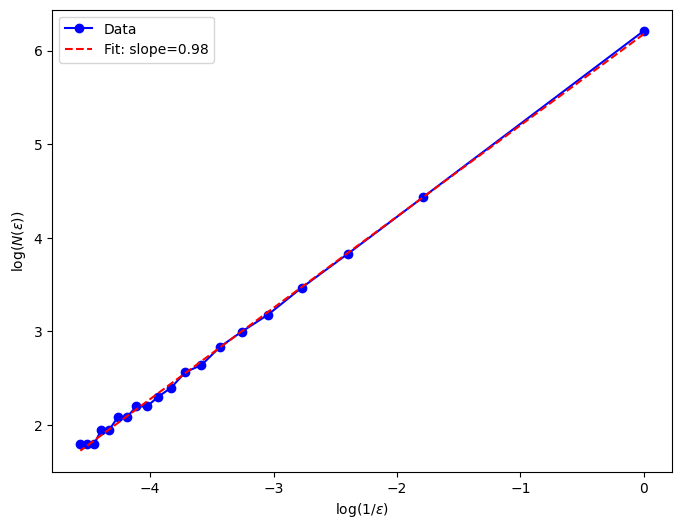

In [43]:
import numpy as np
import matplotlib.pyplot as plt

def box_count(Z, box_size):
    """
    Counts the number of boxes of size box_size that contain part of the signal Z.
    """
    count = 0
    for i in range(0, len(Z), box_size):
        if np.any(Z[i:i+box_size]):
            count += 1
    return count

def fractal_dimension(signal, sizes):
    """
    Calculate the fractal dimension of a signal using the box-counting method.
    """
    N = []
    for size in sizes:
        N.append(box_count(signal, size))
    
    # Fit the points to a line to estimate the slope (fractal dimension)
    coeffs = np.polyfit(np.log(sizes), np.log(N), 1)
    
    return -coeffs[0], coeffs

# Step 1: Generate a sinusoidal signal
x = np.linspace(0, 2*np.pi, 1000)
y = np.sin(x)

print(y)


# Step 2: Discretize the y-values to be binary (for the box-counting method)
y_binary = (y > 0).astype(int)

print(y_binary)

# Step 3: Choose box sizes (different resolutions)
sizes = np.arange(1, 100, 5)

# Step 4: Calculate fractal dimension
dimension, coeffs = fractal_dimension(y_binary, sizes)

# Print the fractal dimension
print(f"Fractal Dimension: {dimension}")

# Plot log-log of N(ε) vs 1/ε
plt.figure(figsize=(8, 6))
plt.plot(np.log(1/sizes), np.log([box_count(y_binary, size) for size in sizes]), 'bo-', label='Data')
plt.plot(np.log(1/sizes), np.polyval(coeffs, np.log(sizes)), 'r--', label=f'Fit: slope={-coeffs[0]:.2f}')
plt.xlabel(r'$\log(1/\epsilon)$')
plt.ylabel(r'$\log(N(\epsilon))$')
plt.legend()
plt.show()

Estimated Fractal Dimension: 1.008636365431184


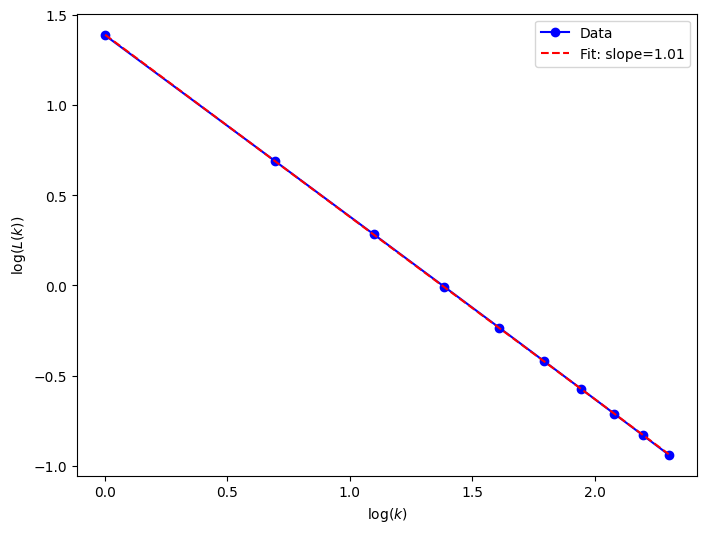

In [49]:
import numpy as np
import matplotlib.pyplot as plt

def higuchi_fractal_dimension(time_series, k_max):
    """
    Calculate the fractal dimension of a time series using Higuchi's algorithm.
    
    Parameters:
    - time_series: The input time series as a 1D numpy array.
    - k_max: The maximum value of k (the parameter that controls segment length).
    
    Returns:
    - The estimated fractal dimension.
    """
    N = len(time_series)
    L = np.zeros(k_max)
    x = np.arange(N)

    for k in range(1, k_max + 1):
        Lk = np.zeros(k)

        for m in range(0, k):
            Lmk = 0
            for i in range(1, int((N - m) / k)):
                Lmk += abs(time_series[m + i * k] - time_series[m + (i - 1) * k])
            Lmk = (Lmk * (N - 1) / (int((N - m) / k) * k)) / k
            Lk[m] = Lmk

        L[k - 1] = np.mean(Lk)

    # Perform linear fit in log-log scale
    ln_k = np.log(range(1, k_max + 1))
    ln_L = np.log(L)
    coeffs = np.polyfit(ln_k, ln_L, 1)

    # The slope of the line is the fractal dimension
    fractal_dimension = -coeffs[0]
    
    return fractal_dimension, coeffs, ln_k, ln_L

# Example usage
# Generate a sample time series (e.g., sine wave, white noise, etc.)
N = 1000
#time_series = np.cumsum(np.random.normal(size=N))  # Example: Random walk (Brownian motion)
#time_series = generate_pink_noise(N)
x = np.linspace(0, 2*np.pi, N)
time_series = np.sin(x)

# Calculate fractal dimension using Higuchi's algorithm
k_max = 10
fractal_dimension, coeffs, ln_k, ln_L = higuchi_fractal_dimension(time_series, k_max)

# Print the result
print(f"Estimated Fractal Dimension: {fractal_dimension}")

# Plot the log-log graph
plt.figure(figsize=(8, 6))
plt.plot(ln_k, ln_L, 'bo-', label='Data')
plt.plot(ln_k, np.polyval(coeffs, ln_k), 'r--', label=f'Fit: slope={-coeffs[0]:.2f}')
plt.xlabel(r'$\log(k)$')
plt.ylabel(r'$\log(L(k))$')
plt.legend()
plt.show()